
This notebook prepares the subject-level mean distances for Liu 2019 kept subjects based on HLA-II alleles that are matched to DRB1 and DQA/DQB & DPA&DPB alleles that are formed by alleles from DeWitt 2018 data.


This is only the first step of the processing

There is another step of processing to add the values from set-based approach


### mean distance between HLA alleles for each subject:

    depth on Zheng 2021 positive TCRs, cor
    
    blosum62-based distance
    
the items below are left for the next notebook:
    
    depth on Zheng 2021 positive TCRs, set

    depth on Zheng 2021 positive TCRs, breadth


In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from collections import Counter

import ot
import ot.plot

import matplotlib.pyplot as plt
import math

In [2]:
# load the info of subjects with HLA-I alleles under our consideration
df_liu_2019 = pd.read_csv("../results/st19_liu_2019_kept_hla_ii_replace_reformat.csv", header=0)
df_liu_2019[:6]

,Unnamed: 0,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,...,biopsy site_categ,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy,hla_class_ii_alleles,homozygous,hla_class_ii_alleles_replace,hla_class_ii_replace_reformat
0,Patient10,96,71,48,22,0.314286,230,0.391384,0,skin,...,skin,3,-12,107,0.83,1.84,"DRB1*04:01,DRB1*15:01,DQA1*01:02,DQA1*03:01,DQ...",1,"DRB1*04:01,DRB1*15:01,DQA1*01:02,DQA1*03:01,DQ...","HLA-DRB1*04:01,HLA-DRB1*15:01,HLA-DQAB*01:02_0..."
1,Patient100,200,126,98,24,0.196721,301,0.029447,0,skin,...,skin,3,-94,33,0.11,2.17,"DRB1*01:01,DRB1*15:01,DQA1*01:01,DQA1*01:02,DQ...",1,"DRB1*01:01,DRB1*15:01,DQA1*01:01,DQA1*01:02,DQ...","HLA-DRB1*01:01,HLA-DRB1*15:01,HLA-DQAB*01:01_0..."
2,Patient102,370,246,215,26,0.107884,825,0.169389,1,brain,...,brain,3,-64,na,0.70,3.24,"DRB1*01:01,DRB1*11:04,DQA1*01:01,DQA1*05:05,DQ...",0,"DRB1*01:01,DRB1*11:04,DQA1*01:01,DQA1*05:05,DQ...","HLA-DRB1*01:01,HLA-DRB1*11:04,HLA-DQAB*01:01_0..."
3,Patient106,380,245,194,36,0.156522,726,0.224147,0,skin,...,skin,3,-74,na,0.62,2.34,"DRB1*03:01,DRB1*10:01,DQA1*01:05,DQA1*05:01,DQ...",0,"DRB1*03:01,DRB1*10:01,DQA1*01:05,DQA1*05:01,DQ...","HLA-DRB1*03:01,HLA-DRB1*10:01,HLA-DQAB*01:05_0..."
4,Patient107,247,158,133,20,0.130719,489,0.144822,1,adrenal gland,...,liver/visceral,3,-132,na,0.76,5.08,"DRB1*04:02,DRB1*07:01,DQA1*02:01,DQA1*03:01,DQ...",0,"DRB1*04:02,DRB1*07:01,DQA1*02:01,DQA1*03:01,DQ...","HLA-DRB1*04:02,HLA-DRB1*07:01,HLA-DQAB*02:01_0..."
5,Patient11,246,172,131,35,0.210843,560,0.238964,0,skin,...,skin,3,-8,516,0.77,3.43,"DRB1*01:01,DRB1*13:01,DQA1*01:01,DQA1*01:03,DQ...",0,"DRB1*01:01,DRB1*13:01,DQA1*01:01,DQA1*01:03,DQ...","HLA-DRB1*01:01,HLA-DRB1*13:01,HLA-DQAB*01:01_0..."


In [3]:
df_liu_2019.shape

(120, 50)

In [4]:
df_liu_2019.isna().sum()

Unnamed: 0                                                  0
total_muts                                                  0
nonsyn_muts                                                 0
clonal_muts                                                 0
subclonal_muts                                              0
heterogeneity                                               0
total_neoantigens                                           0
CNA_prop                                                    0
gender (Male=1, Female=0)                                   0
biopsy site                                                 0
monthsBiopsyPreTx                                           0
BR                                                          0
PFS                                                         0
OS                                                          0
TimeToBR                                                    0
cyclesOnTherapy                                             0
txOngoin

In [5]:
# load HLA-I distance matrix based on zheng 2021 pos tcrs or pseudo sequences

df_depth = pd.read_csv("../results/st21_zheng_2021_pos_HLA_II_dist_ensemble_20.csv", header=0)

df_blosum62 = pd.read_csv("../results/st22_blosum62_HLA_II_dist.csv", header=0)

In [6]:
print(df_depth.shape)
print(df_blosum62.shape)

(141, 141)
(141, 141)


In [7]:
# load HLA-II allele names

df_hla = pd.read_csv("../data/Liu_2019/liu_2019_hla_ii_format.csv", header=0)

In [8]:
df_hla.shape

(141, 1)

In [9]:
df_hla[:2]

,hla
0,HLA-DPAB*01:03_01:01
1,HLA-DPAB*01:03_02:01


In [10]:
hla_ii_141_format = df_hla.hla.tolist()

In [11]:
# create a dictionary for the distance between any two hla i alleles under each situation


# for DePTH zheng 2021 based

depth_dict = defaultdict(float)

for i, a in enumerate(hla_ii_141_format):
    cur_list = df_depth.iloc[:, i].tolist()
    for j, b in enumerate(hla_ii_141_format):
        depth_dict[(a, b)] = cur_list[j]

In [12]:
# for blosum62 based 
blosum62_dict = defaultdict(float)

for i, a in enumerate(hla_ii_141_format):
    cur_list = df_blosum62.iloc[:, i].tolist()
    for j, b in enumerate(hla_ii_141_format):
        blosum62_dict[(a, b)] = cur_list[j]

In [13]:
# plot the distances from two lists of TCRs for the same HLA pairs

test_depth_dict_keys = list(depth_dict.keys())

test_depth_values = [depth_dict[x] for x in test_depth_dict_keys]

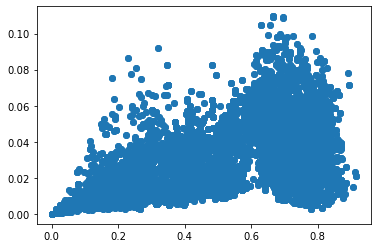

In [15]:
# plot the distances from zheng 2021 positive TCRs and blosum62 for the same HLA pairs
plt.scatter(blosum62_dict.values(), depth_dict.values())
plt.show()

In [16]:
df_liu_2019.hla_class_ii_replace_reformat.tolist()[:2]

['HLA-DRB1*04:01,HLA-DRB1*15:01,HLA-DQAB*01:02_03:02,HLA-DQAB*01:02_06:02,HLA-DQAB*03:01_03:02,HLA-DQAB*03:01_06:02,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01',
 'HLA-DRB1*01:01,HLA-DRB1*15:01,HLA-DQAB*01:01_05:01,HLA-DQAB*01:01_06:02,HLA-DQAB*01:02_05:01,HLA-DQAB*01:02_06:02,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01']

In [17]:
# verify whether each subject has two alleles for DRB, four alleles for DQ and four alleles for DP
# the answer is true

genotype_replace_list = [x.split(",") for x in df_liu_2019.hla_class_ii_replace_reformat.tolist()]

RQP_replace_list = []

for genotype in genotype_replace_list:
    RQP_replace_list += ["".join([list(x)[5] for x in genotype])]

Counter(RQP_replace_list)

Counter({'RRQQQQPPPP': 120})

In [18]:
set([x for y in genotype_replace_list for x in y]) == set(df_hla.hla)

True

In [19]:
# compute the distance based on both two TCR resources and pseudo sequence
# based on blosum62 for each subject

# for DRB, take the distance between the two
# for DQAB, take the average of pairwise distances from the four
# for DPAB, take the average of pairwise distances from the four


def ave_six(input_list, input_dict):
    
    temp_dist = 0
    
    for i in range(3):
        for j in range((i+1),4):
            temp_dist += input_dict[(input_list[i], input_list[j])]
            
    temp_result = temp_dist/6
    return temp_result



depth_rr = []
depth_qq = []
depth_pp = []

for genotype in genotype_replace_list:
    
    depth_rr += [depth_dict[(genotype[0], genotype[1])]]
    
    depth_qq += [ave_six(genotype[2:6], depth_dict)]   
    depth_pp += [ave_six(genotype[6:], depth_dict)]

depth_ave = [(x+y+z)/3 for x,y,z in zip(depth_rr, depth_qq, depth_pp)]



# use HLAI_Genotype_replace for aa as well
aa_rr = []
aa_qq = []
aa_pp = []

for genotype in genotype_replace_list:
    
    aa_rr += [blosum62_dict[(genotype[0], genotype[1])]]
    
    aa_qq += [ave_six(genotype[2:6], blosum62_dict)]   
    aa_pp += [ave_six(genotype[6:], blosum62_dict)]

aa_ave = [(x+y+z)/3 for x,y,z in zip(aa_rr, aa_qq, aa_pp)]

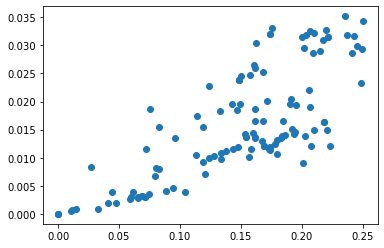

In [20]:
plt.scatter(aa_ave, depth_ave)
plt.show()

In [22]:
df_liu_2019["depth_ave"] = depth_ave
df_liu_2019["aa_ave"] = aa_ave

In [23]:
df_liu_2019.isna().sum()

Unnamed: 0                                                  0
total_muts                                                  0
nonsyn_muts                                                 0
clonal_muts                                                 0
subclonal_muts                                              0
heterogeneity                                               0
total_neoantigens                                           0
CNA_prop                                                    0
gender (Male=1, Female=0)                                   0
biopsy site                                                 0
monthsBiopsyPreTx                                           0
BR                                                          0
PFS                                                         0
OS                                                          0
TimeToBR                                                    0
cyclesOnTherapy                                             0
txOngoin

In [24]:
# save the extended df_liu_2019 file out
df_liu_2019.to_csv("../results/st23_liu_2019_depth_aa_scores.csv", index = False)